# Part 0: Load in libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import localcider
from localcider.sequenceParameters import SequenceParameters
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from scipy.stats import fisher_exact

# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Load in IDR data

In [2]:
humandf=pd.read_excel('../general_data/All_sapiens_IDRs_clustermap_using_centroids.xlsx',engine='openpyxl')

print(humandf.isnull().any())
humandf = humandf.fillna('')

fullaccs=humandf['Uniprot'].tolist()
fullaccswnums=humandf['Uniprot w IDRnum'].tolist()
fullgeneswnums=humandf['Gene'].tolist()
fullclusternum=humandf['Cluster Number'].tolist()
fullseqlens=humandf['IDR Length'].tolist()
fullstpos=humandf['Start Pos'].tolist()
fullenpos=humandf['End Pos'].tolist()
fullproteinlength=humandf['Full Protein Length'].tolist()
fullmininterclustdist=humandf['Min Inter Clust Dist'].tolist()
fulltermini=humandf['IDR Position'].tolist()
fulllocationbyunistring=humandf['HPA Location'].tolist()
fullseqs=humandf['Sequence'].tolist()

print(humandf)

fullgenes=[]
for i in range(0,len(fullgeneswnums)):
    tmp=fullgeneswnums[i].split(' ')
    fullgenes.append(tmp[0])

humandf['Gene no Num']=fullgenes

# make sure features match
myfeat=['pol-pol','pol-hyd','pol-pos','pol-neg','pol-aro','pol-ala','pol-pro','pol-gly','hyd-hyd','hyd-pos','hyd-neg','hyd-aro','hyd-ala','hyd-pro','hyd-gly','pos-pos','pos-neg','pos-aro','pos-ala','pos-pro','pos-gly','neg-neg','neg-aro','neg-ala','neg-pro','neg-gly','aro-aro','aro-ala','aro-pro','aro-gly','ala-ala','ala-pro','ala-gly','pro-pro','pro-gly','gly-gly','Frac A','Frac C','Frac D','Frac E','Frac F','Frac G','Frac H','Frac I','Frac K','Frac L','Frac M','Frac N','Frac P','Frac Q','Frac R','Frac S','Frac T','Frac V','Frac W','Frac Y','Frac K+R','Frac D+E','Frac Polar','Frac Aliphatic','Frac Aromatic','R/K Ratio','E/D Ratio','Frac Chain Expanding','FCR','NCPR','Hydrophobicity','Disorder Promoting','Iso point','PPII','A Patch','C Patch','D Patch','E Patch','F Patch','G Patch','H Patch','I Patch','K Patch','L Patch','M Patch','N Patch','P Patch','Q Patch','R Patch','S Patch','T Patch','V Patch','Y Patch','RG Frac']
print(len(myfeat))

# Load in z-scores for all human IDRs
# Made in /project/fava/work/kiersten.ruff/Collaborations/Su/2023/Library_design/map_clusters_for_all_human_IDRs.ipynb
fullzvec=np.load('../general_data/sapiens_full_idrome_gte_30_nardini_compositional_RtoK.npy')
print(fullzvec.shape)

Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location             True
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
1               1  Q9NRJ4         Q9NRJ4_1      TULP4 IDR1              17   
2               2  Q9NRJ4         Q9NRJ4_2      TULP4 IDR2               1   
3               3  Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              27   
4               4  Q9NRJ4         Q9NRJ4_4      TULP4 IDR4              27   
...           ...     ...              ...             ...             ...   
24503       24503  Q7Z739         Q7Z739_2     YTHDF

# Part 2: Analyze overlap of high fitness correlation proteins

## 2.1 - Load in fitness correlation data from DepMap

In [5]:
currgenes=['UBTF','MAML3']
corrcoff=0.1

dmgenes=[]
dmcorr=[]
for g in range(0,len(currgenes)):
    dmdf=pd.read_csv('data/DepMap/'+currgenes[g]+'_DepMap_Public_24Q2_Files_top_contain_'+str(corrcoff)+'.csv')

    dmdf=dmdf[dmdf['numCellLines']==1150]
    dmdf=dmdf[dmdf['Cor']>=corrcoff]
    print(dmdf)

    dmgenes.append(dmdf['label'].tolist())
    dmcorr.append(dmdf['Cor'].tolist())

          Cor        PValue        QValue    label  numCellLines
0    1.000000  0.000000e+00  0.000000e+00     UBTF          1150
44   0.221219  3.250442e-14  2.780265e-10    TAF1C          1150
51   0.211513  4.257394e-13  2.427708e-09    TAF1A          1150
54   0.200475  6.847756e-12  2.628582e-08   POLR1E          1150
55   0.200004  7.682769e-12  2.628582e-08  PAK1IP1          1150
..        ...           ...           ...      ...           ...
315  0.100642  6.310440e-04  3.092173e-02   EXOSC2          1150
316  0.100622  6.326418e-04  3.092173e-02    PANX1          1150
317  0.100497  6.425892e-04  3.096556e-02   CHCHD4          1150
318  0.100205  6.665535e-04  3.185120e-02     TMPO          1150
319  0.100007  6.832477e-04  3.255799e-02    KIF1B          1150

[213 rows x 5 columns]
          Cor        PValue        QValue    label  numCellLines
0    1.000000  0.000000e+00  0.000000e+00    MAML3          1150
172  0.200424  6.933758e-12  2.965395e-08   KNSTRN          1150
1

## 2.2 - Plot venn diagram of correlated proteins

Text(0.5, 1.0, 'Genes with correlated fitness >=0.1 for 1150 cell lines')

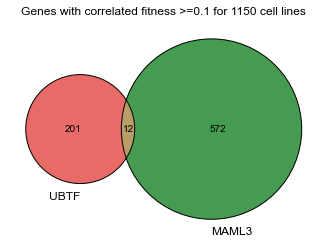

In [7]:
from matplotlib_venn import venn2,venn2_circles

venn2([set(dmgenes[0]),set(dmgenes[1])], set_labels = (currgenes[0], currgenes[1]), set_colors=('#e23a36','#077a15'), alpha=0.75)
venn2_circles([set(dmgenes[0]),set(dmgenes[1])],linewidth=1)

plt.title('Genes with correlated fitness >='+str(corrcoff)+' for 1150 cell lines')

#plt.savefig('/project/fava/work/kiersten.ruff/Collaborations/Kadoch/2024/GIN_nucleus/DepMap/data/single_protein/figures/'+currgenes[0]+'vs_'+currgenes[1]+'_venn_diagram_corr_gte_'+str(corrcoff)+'_top_'+str(topnum)+'.pdf', transparent=False, bbox_inches = "tight")


## 2.3 - Save highly correlated proteins

In [12]:
for i in range(0,len(currgenes)):
    dftmp=pd.DataFrame()
    dftmp[currgenes[i]+' Positively Correlated Proteins Names']=dmgenes[i]
    dftmp[currgenes[i]+' Positively Correlated Proteins Values']=dmcorr[i]
    print(dftmp)
    
    print('Fig_7F_'+currgenes[i])
    
    #with pd.ExcelWriter('../Supplementary_Tables/Table_S7.xlsx', engine='openpyxl',mode='a') as writer:
    #    dftmp.to_excel(writer,sheet_name='Fig_7F_'+currgenes[i])

    UBTF Positively Correlated Proteins Names  \
0                                        UBTF   
1                                       TAF1C   
2                                       TAF1A   
3                                      POLR1E   
4                                     PAK1IP1   
..                                        ...   
208                                    EXOSC2   
209                                     PANX1   
210                                    CHCHD4   
211                                      TMPO   
212                                     KIF1B   

     UBTF Positively Correlated Proteins Values  
0                                      1.000000  
1                                      0.221219  
2                                      0.211513  
3                                      0.200475  
4                                      0.200004  
..                                          ...  
208                                    0.100642  
209        

# Part 3: d3 Graphs of correlation for UBTF

## 3.1 - Load in data

In [3]:
currgene='UBTF'
corrcoff=0.1
hcorrcoff=0.17
#topnum=12

tmpdf=pd.read_excel('data/DepMap/'+currgene+'_all_pairwise_correlation_corrcoff_gte_'+str(corrcoff)+'.xlsx',engine='openpyxl')
print(tmpdf)
mycolnames=tmpdf.columns.tolist()
currgenewnum=mycolnames[2]
print(currgenewnum)

tmplist=tmpdf['Unnamed: 0.1'].tolist()
tmpval=tmpdf[currgenewnum].tolist()

topgenelist=['Unnamed: 0.1']
for i in range(0,len(tmplist)):
    if tmpval[i]>=hcorrcoff:
        topgenelist.append(tmplist[i])
#print(topgenelist)
print(len(topgenelist))

tmpdf2=tmpdf[topgenelist]
tmpdf2=tmpdf2.sort_values(by=currgenewnum,ascending=False)
tmpdf2=tmpdf2[tmpdf2['Unnamed: 0.1'].isin(topgenelist)]
print(tmpdf2)

     Unnamed: 0     Unnamed: 0.1  UBTF (7343)  TAF1C (9013)  TAF1A (9015)  \
0         15805      UBTF (7343)     1.000000      0.221219      0.211513   
1         14366     TAF1C (9013)     0.221219      1.000000      0.277564   
2         14364     TAF1A (9015)     0.211513      0.277564      1.000000   
3         11053   POLR1E (64425)     0.200475      0.320976      0.164466   
4         10229  PAK1IP1 (55003)     0.200004      0.270196      0.210345   
..          ...              ...          ...           ...           ...   
208        4793   EXOSC2 (23404)     0.100642      0.144069      0.082796   
209       10252    PANX1 (24145)     0.100622      0.029364     -0.011377   
210        2750  CHCHD4 (131474)     0.100497      0.198392      0.088048   
211       15134      TMPO (7112)     0.100205      0.043066      0.092151   
212        7472    KIF1B (23095)     0.100007     -0.012123      0.020535   

     POLR1E (64425)  PAK1IP1 (55003)  SPOUT1 (51490)  DDX10 (1662)  \
0    

## 3.2 - Create data for graph

In [10]:
genelistrows=tmpdf2['Unnamed: 0.1'].tolist()

source=[]
target=[]
weight=[]
for g in range(1,len(topgenelist)):
    currrow=genelistrows[g:]
    currcol=tmpdf2[topgenelist[g]].tolist()[g:]
    pos=[i for i, x in enumerate(currcol) if x>= 0.17]
    #print(pos)
    for p in pos:
        source.append(topgenelist[g])
        target.append(currrow[p])
        weight.append(currcol[p]*100)

graphdf=pd.DataFrame()
graphdf['source']=source
graphdf['target']=target
graphdf['weight']=weight
print(graphdf)

testdf=graphdf.sort_values(by=['weight'],ascending=False)
print(testdf.head(50))

#with pd.ExcelWriter('../Supplementary_Tables/Table_S7.xlsx', engine='openpyxl',mode='a') as writer:
#    graphdf.to_excel(writer,sheet_name='Fig_S7C')

            source           target     weight
0      UBTF (7343)     TAF1C (9013)  22.121871
1      UBTF (7343)     TAF1A (9015)  21.151349
2      UBTF (7343)   POLR1E (64425)  20.047462
3      UBTF (7343)  PAK1IP1 (55003)  20.000359
4      UBTF (7343)   SPOUT1 (51490)  19.179672
..             ...              ...        ...
85  POLR1H (30834)     TAF1B (9014)  18.034523
86  POLR1H (30834)    WDR18 (57418)  27.324714
87  POLR1H (30834)      NOP2 (4839)  17.500947
88    TAF1B (9014)    WDR18 (57418)  23.079134
89   WDR18 (57418)      NOP2 (4839)  26.662133

[90 rows x 3 columns]
             source           target     weight
38   POLR1E (64425)   POLR1H (30834)  52.041669
83      DKC1 (1736)    WDR18 (57418)  51.144531
35   POLR1E (64425)   POLR1G (10849)  47.984600
46  PAK1IP1 (55003)      DKC1 (1736)  45.967159
49  PAK1IP1 (55003)    WDR18 (57418)  44.934145
69   POLR1G (10849)   POLR1H (30834)  43.378042
26     TAF1C (9013)    WDR18 (57418)  41.977267
32     TAF1A (9015)     TAF1B

## 3.3 - Graph data

In [9]:
from d3blocks import D3Blocks
d3 = D3Blocks()

#graphdf = d3.import_example('energy') # 'bigbang', 'stormofswords'
#print(graphdf)
d3.d3graph(graphdf, filepath='d3graph.html')
d3.d3graph.set_node_properties(color=None)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Set directed=True to see the markers!
[d3blocks] >INFO> Keep only edges with weight>0
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Converting adjacency matrix into source-target..
[d3blocks] >INFO> Number of unique nodes: 17
[d3blocks] >INFO> Slider range is set to [16, 53]
[d3blocks] >INFO> Write to path: [/tmp/tmptkkfwf5o/d3graph.html]
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/tmptkkfwf5o/d3graph.html]


AttributeError: 'function' object has no attribute 'set_node_properties'

# Part 4: d3 Graphs of correlation for MAML3

## 4.1 - Load in data

In [35]:
currgene='MAML3'
corrcoff=0.1
hcorrcoff=0.17
#topnum=12

tmpdf=pd.read_excel('data/DepMap/'+currgene+'_all_pairwise_correlation_corrcoff_gte_'+str(corrcoff)+'.xlsx',engine='openpyxl')
print(tmpdf)
mycolnames=tmpdf.columns.tolist()
currgenewnum=mycolnames[2]
print(currgenewnum)

tmplist=tmpdf['Unnamed: 0.1'].tolist()
tmpval=tmpdf[currgenewnum].tolist()

topgenelist=['Unnamed: 0.1']
for i in range(0,len(tmplist)):
    if tmpval[i]>=hcorrcoff:
        topgenelist.append(tmplist[i])
#print(topgenelist)
print(len(topgenelist))

tmpdf2=tmpdf[topgenelist]
tmpdf2=tmpdf2.sort_values(by=currgenewnum,ascending=False)
tmpdf2=tmpdf2[tmpdf2['Unnamed: 0.1'].isin(topgenelist)]
print(tmpdf2)

     Unnamed: 0    Unnamed: 0.1  MAML3 (55534)  KNSTRN (90417)  OPRD1 (4985)  \
0          8340   MAML3 (55534)       1.000000        0.200424      0.196789   
1          7625  KNSTRN (90417)       0.200424        1.000000      0.218540   
2         10075    OPRD1 (4985)       0.196789        0.218540      1.000000   
3          5262     FLNA (2316)       0.196273        0.098620      0.196641   
4          3484    CTRC (11330)       0.185589        0.082352      0.210261   
..          ...             ...            ...             ...           ...   
579         271  ADAMTS2 (9509)       0.100476        0.109882      0.222344   
580       16698  ZNF304 (57343)       0.100474        0.131402      0.094342   
581        6397   HERC6 (55008)       0.100397       -0.056413      0.002306   
582       13538   SLIRP (81892)       0.100183        0.160018      0.155777   
583       14294  SYNGAP1 (8831)       0.100160        0.052465      0.066892   

     FLNA (2316)  CTRC (11330)  MEGF9 (

## 4.2 - Create data for graph

In [38]:
genelistrows=tmpdf2['Unnamed: 0.1'].tolist()

source=[]
target=[]
weight=[]
for g in range(1,len(topgenelist)):
    currrow=genelistrows[g:]
    currcol=tmpdf2[topgenelist[g]].tolist()[g:]
    pos=[i for i, x in enumerate(currcol) if x>= 0.17]
    #print(pos)
    for p in pos:
        source.append(topgenelist[g])
        target.append(currrow[p])
        weight.append(currcol[p]*100)

graphdf=pd.DataFrame()
graphdf['source']=source
graphdf['target']=target
graphdf['weight']=weight
print(graphdf)

testdf=graphdf.sort_values(by=['weight'],ascending=False)
print(testdf.head(50))

#with pd.ExcelWriter('../Supplementary_Tables/Table_S7.xlsx', engine='openpyxl',mode='a') as writer:
#    graphdf.to_excel(writer,sheet_name='Fig_S7D')

            source          target     weight
0    MAML3 (55534)  KNSTRN (90417)  20.042358
1    MAML3 (55534)    OPRD1 (4985)  19.678914
2    MAML3 (55534)     FLNA (2316)  19.627329
3    MAML3 (55534)    CTRC (11330)  18.558890
4    MAML3 (55534)    MEGF9 (1955)  17.976878
5    MAML3 (55534)     GPX3 (2878)  17.956084
6    MAML3 (55534)  PLXND1 (23129)  17.896595
7    MAML3 (55534)   IRX2 (153572)  17.674539
8    MAML3 (55534)   GABRR1 (2569)  17.419976
9    MAML3 (55534)     ISL1 (3670)  17.381725
10   MAML3 (55534)       ACP1 (52)  17.371004
11   MAML3 (55534)    TNIK (23043)  17.363147
12   MAML3 (55534)   LRP11 (84918)  17.191278
13   MAML3 (55534)  ZNF764 (92595)  17.175359
14   MAML3 (55534)    GPR26 (2849)  17.116614
15   MAML3 (55534)  ENPP6 (133121)  17.070774
16  KNSTRN (90417)    OPRD1 (4985)  21.853970
17  KNSTRN (90417)     GPX3 (2878)  20.063341
18  KNSTRN (90417)  PLXND1 (23129)  19.551886
19  KNSTRN (90417)  ZNF764 (92595)  19.252675
20    OPRD1 (4985)     FLNA (2316)

/home/research/kiersten.ruff/.local/lib/python3.6/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


## 4.3 - Graph data

In [37]:
from d3blocks import D3Blocks
d3 = D3Blocks()

#graphdf = d3.import_example('energy') # 'bigbang', 'stormofswords'
#print(graphdf)
d3.d3graph(graphdf, filepath='d3graph.html')
d3.d3graph.set_node_properties(color=None)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Set directed=True to see the markers!
[d3blocks] >INFO> Keep only edges with weight>0
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Converting adjacency matrix into source-target..
[d3blocks] >INFO> Number of unique nodes: 17
[d3blocks] >INFO> Slider range is set to [16, 28]
[d3blocks] >INFO> Write to path: [/tmp/tmpn_nkv4us/d3graph.html]
[d3blocks] >INFO> File already exists and will be overwritten: [/tmp/tmpn_nkv4us/d3graph.html]


AttributeError: 'function' object has no attribute 'set_node_properties'